# 🧬 BLOOD GROUP & GENOTYPE PREDICTION USING MACHINE LEARNING

---

## **1. INTRODUCTION**

The goal of this project is to automate the interpretation of laboratory test results for **blood group** and **genotype** using machine learning.  
In traditional lab settings, technicians manually observe reactions between antisera (Anti-A, Anti-B, Anti-D) and blood samples to determine blood groups, and interpret sickling, solubility, and electrophoresis results to determine genotypes.  

This process can be time-consuming and prone to human error.  

This project builds a Python-based system that learns these relationships and predicts results automatically from the test parameters — simulating a **digital laboratory assistant**.

### **Objectives**
- Create and clean a unified dataset for blood group and genotype tests.  
- Derive test parameters (Anti-A, Anti-B, Anti-D, Sickling, Solubility, Bands).  
- Train and compare multiple models (Logistic Regression, KNN, Decision Tree, Random Forest, SVM).  
- Evaluate performance using accuracy, confusion matrix, and feature importance.  
- Save the best models for later deployment or Streamlit app integration.


# DATA PREPARATION AND FEATURE ENGINEERING

In [3]:
import pandas as pd

# Load your main dataset (must have 'Blood_Group' and 'Genotype' columns)
df = pd.read_excel(r"C:\Users\USER\Documents\BLD GRP & GENE.xlsx")

# --- CLEAN COLUMNS FIRST ---
df['Blood Group'] = df['Blood Group'].astype(str).str.strip().str.replace('＋', '+').str.replace('－', '-')
df['Blood Group'] = df['Blood Group'].str.replace(' ', '')  # remove hidden spaces
df['Genotype'] = df['Genotype'].astype(str).str.strip().str.upper()

# --- GENERATE BLOOD GROUP TEST PARAMETERS ---
df['Anti_A'] = df['Blood Group'].apply(
    lambda x: 1 if 'A' in x and 'AB' not in x else (1 if 'AB' in x else 0)
)
df['Anti_B'] = df['Blood Group'].apply(lambda x: 1 if 'B' in x else 0)
df['Anti_D'] = df['Blood Group'].apply(lambda x: 1 if '+' in x else 0)

# --- GENERATE GENOTYPE TEST PARAMETERS ---
df['Sickling'] = df['Genotype'].map({
    'AA': 'No',
    'AS': 'Few',
    'SS': 'Yes',
    'AC': 'No',
    'CC': 'No',
    'SC': 'Few'
})

df['Solubility'] = df['Genotype'].map({
    'AA': 'Clear',
    'AS': 'Cloudy',
    'SS': 'Cloudy',
    'AC': 'Clear',
    'CC': 'Clear',
    'SC': 'Cloudy'
})

df['Bands'] = df['Genotype'].map({
    'AA': 'A',
    'AS': 'A and S',
    'SS': 'S',
    'AC': 'A and C',
    'CC': 'C',
    'SC': 'S and C'
})

# --- ADD A SAMPLE_ID FOR CLARITY ---
df.insert(0, 'Sample_ID', range(1, len(df) + 1))

# --- SELECT AND ORDER COLUMNS FOR CLARITY ---
df = df[['Sample_ID', 'Blood Group', 'Anti_A', 'Anti_B', 'Anti_D',
         'Genotype', 'Sickling', 'Solubility', 'Bands']]

# --- SAVE THE RAW (UNENCODED) DATASET ---
df.to_excel('raw_blood_and_genotype_dataset.xlsx', index=False)

print("✅ Merged raw dataset created successfully as 'raw_blood_and_genotype_dataset.xlsx'")
print(df.head(10))


✅ Merged raw dataset created successfully as 'raw_blood_and_genotype_dataset.xlsx'
   Sample_ID Blood Group  Anti_A  Anti_B  Anti_D Genotype Sickling Solubility  \
0          1          A+       1       0       1       AS      Few     Cloudy   
1          2          O+       0       0       1       AA       No      Clear   
2          3          A+       1       0       1       AS      Few     Cloudy   
3          4          O+       0       0       1       AA       No      Clear   
4          5          O+       0       0       1       AA       No      Clear   
5          6          O+       0       0       1       AA       No      Clear   
6          7          A+       1       0       1       AA       No      Clear   
7          8          O+       0       0       1       AA       No      Clear   
8          9          O+       0       0       1       AA       No      Clear   
9         10         AB+       1       1       1       AA       No      Clear   

     Bands  
0  A and S  

In [4]:
df

,Sample_ID,Blood Group,Anti_A,Anti_B,Anti_D,Genotype,Sickling,Solubility,Bands
0,1,A+,1,0,1,AS,Few,Cloudy,A and S
1,2,O+,0,0,1,AA,No,Clear,A
2,3,A+,1,0,1,AS,Few,Cloudy,A and S
3,4,O+,0,0,1,AA,No,Clear,A
4,5,O+,0,0,1,AA,No,Clear,A
...,...,...,...,...,...,...,...,...,...
3316,3317,O+,0,0,1,AA,No,Clear,A
3317,3318,O+,0,0,1,AC,No,Clear,A and C
3318,3319,B+,0,1,1,AA,No,Clear,A
3319,3320,B+,0,1,1,AA,No,Clear,A


In [5]:
import os

# Create a folder if it doesn't exist
os.makedirs('datasets', exist_ok=True)

# Save inside that folder
df.to_excel('datasets/raw_blood_and_genotype_dataset.xlsx', index=False)
df.to_csv('datasets/raw_blood_and_genotype_dataset.csv', index=False)

print("✅ Saved successfully in the 'datasets' folder.")

✅ Saved successfully in the 'datasets' folder.


In [6]:

df_check = pd.read_excel('datasets/raw_blood_and_genotype_dataset.xlsx')
print(df_check.head())


   Sample_ID Blood Group  Anti_A  Anti_B  Anti_D Genotype Sickling Solubility  \
0          1          A+       1       0       1       AS      Few     Cloudy   
1          2          O+       0       0       1       AA       No      Clear   
2          3          A+       1       0       1       AS      Few     Cloudy   
3          4          O+       0       0       1       AA       No      Clear   
4          5          O+       0       0       1       AA       No      Clear   

     Bands  
0  A and S  
1        A  
2  A and S  
3        A  
4        A  


In [7]:
df['Blood Group'].value_counts()

Blood Group
O+     1703
A+      664
B+      663
O-      116
AB+      92
A-       42
B-       35
AB-       6
Name: count, dtype: int64

In [8]:
df['Genotype'].value_counts()

Genotype
AA    2465
AS     693
AC     131
SS      16
SC      12
CC       4
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sample_ID    3321 non-null   int64 
 1   Blood Group  3321 non-null   object
 2   Anti_A       3321 non-null   int64 
 3   Anti_B       3321 non-null   int64 
 4   Anti_D       3321 non-null   int64 
 5   Genotype     3321 non-null   object
 6   Sickling     3321 non-null   object
 7   Solubility   3321 non-null   object
 8   Bands        3321 non-null   object
dtypes: int64(4), object(5)
memory usage: 233.6+ KB


In [10]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Sample_ID      0
Blood Group    0
Anti_A         0
Anti_B         0
Anti_D         0
Genotype       0
Sickling       0
Solubility     0
Bands          0
dtype: int64


In [11]:
# Clean again to remove accidental spaces or weird symbols
df['Blood Group'] = df['Blood Group'].astype(str).str.strip().str.replace('＋', '+').str.replace('－', '-')
df['Blood Group'] = df['Blood Group'].str.replace(' ', '')

df['Genotype'] = df['Genotype'].astype(str).str.strip().str.upper()


In [12]:
from sklearn.preprocessing import LabelEncoder

# Make a copy
df_encoded = df.copy()

# --- Encode input features manually (to preserve meaning) ---
df_encoded['Sickling'] = df_encoded['Sickling'].map({'No': 0, 'Few': 0.5, 'Yes': 1})
df_encoded['Solubility'] = df_encoded['Solubility'].map({'Clear': 0, 'Cloudy': 1})
df_encoded['Bands'] = df_encoded['Bands'].map({
    'A': 0, 'A and S': 1, 'S': 2, 'A and C': 3, 'C': 4, 'S and C': 5
})

# --- Encode targets using LabelEncoder ---
le_bg = LabelEncoder()
df_encoded['Blood Group'] = le_bg.fit_transform(df_encoded['Blood Group'])

le_geno = LabelEncoder()
df_encoded['Genotype'] = le_geno.fit_transform(df_encoded['Genotype'])

# Save for later use
import joblib
joblib.dump(le_bg, 'labelencoder_bloodgroup.pkl')
joblib.dump(le_geno, 'labelencoder_genotype.pkl')


['labelencoder_genotype.pkl']

In [13]:
df_encoded

,Sample_ID,Blood Group,Anti_A,Anti_B,Anti_D,Genotype,Sickling,Solubility,Bands
0,1,0,1,0,1,2,0.5,1,1
1,2,6,0,0,1,0,0.0,0,0
2,3,0,1,0,1,2,0.5,1,1
3,4,6,0,0,1,0,0.0,0,0
4,5,6,0,0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
3316,3317,6,0,0,1,0,0.0,0,0
3317,3318,6,0,0,1,1,0.0,0,3
3318,3319,4,0,1,1,0,0.0,0,0
3319,3320,4,0,1,1,0,0.0,0,0


In [14]:
df.sample(10)

,Sample_ID,Blood Group,Anti_A,Anti_B,Anti_D,Genotype,Sickling,Solubility,Bands
1374,1375,O+,0,0,1,AA,No,Clear,A
643,644,B+,0,1,1,AA,No,Clear,A
1824,1825,A+,1,0,1,AA,No,Clear,A
3265,3266,A+,1,0,1,AA,No,Clear,A
2036,2037,AB+,1,1,1,AA,No,Clear,A
818,819,O+,0,0,1,AA,No,Clear,A
2992,2993,A+,1,0,1,AA,No,Clear,A
267,268,B+,0,1,1,AA,No,Clear,A
537,538,B+,0,1,1,AA,No,Clear,A
585,586,O+,0,0,1,AA,No,Clear,A


In [15]:
df_encoded.sample(10)

,Sample_ID,Blood Group,Anti_A,Anti_B,Anti_D,Genotype,Sickling,Solubility,Bands
1794,1795,0,1,0,1,0,0.0,0,0
2508,2509,6,0,0,1,2,0.5,1,1
2053,2054,6,0,0,1,0,0.0,0,0
2630,2631,6,0,0,1,2,0.5,1,1
1483,1484,4,0,1,1,0,0.0,0,0
3207,3208,4,0,1,1,2,0.5,1,1
2020,2021,0,1,0,1,0,0.0,0,0
2213,2214,6,0,0,1,1,0.0,0,3
962,963,4,0,1,1,2,0.5,1,1
404,405,6,0,0,1,0,0.0,0,0


In [16]:
df['Blood Group'].unique()

array(['A+', 'O+', 'AB+', 'B+', 'O-', 'A-', 'AB-', 'B-'], dtype=object)

In [17]:
df['Genotype'].unique()

array(['AS', 'AA', 'AC', 'CC', 'SS', 'SC'], dtype=object)

In [18]:
# Define features and target
X_bg = df[['Anti_A', 'Anti_B', 'Anti_D']]
y_bg = df['Blood Group']

In [19]:
from sklearn.model_selection import train_test_split

X_bg_train, X_bg_test, y_bg_train, y_bg_test = train_test_split(
    X_bg, y_bg, test_size=0.2, random_state=42
)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_bg_train, y_bg_train)
    y_pred = model.predict(X_bg_test)
    acc = accuracy_score(y_bg_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.9955
KNN Accuracy: 1.0000
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000


C:\Users\USER\AppData\Local\Temp\ipykernel_5908\1852487595.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Greens_r')


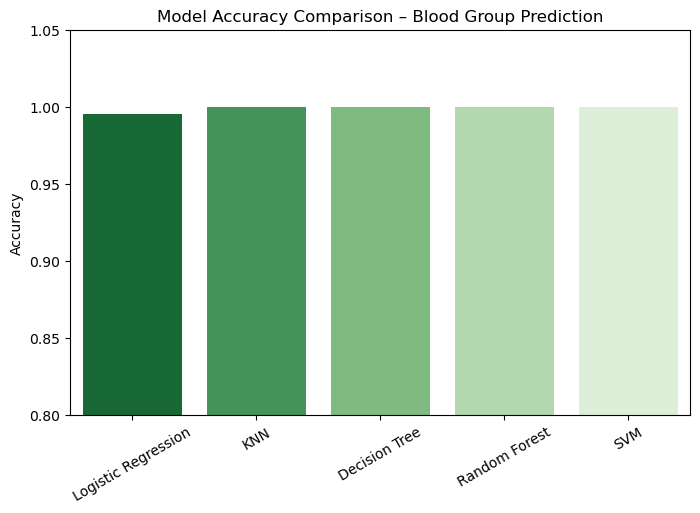

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Greens_r')
plt.title('Model Accuracy Comparison – Blood Group Prediction')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.ylim(0.8, 1.05)
plt.show()


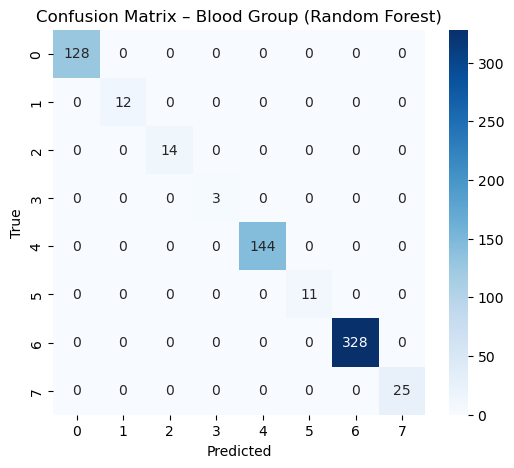

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_bg_train, y_bg_train)
y_pred_best = best_model.predict(X_bg_test)

cm = confusion_matrix(y_bg_test, y_pred_best, labels=best_model.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Blood Group (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_5908\920712298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='viridis')


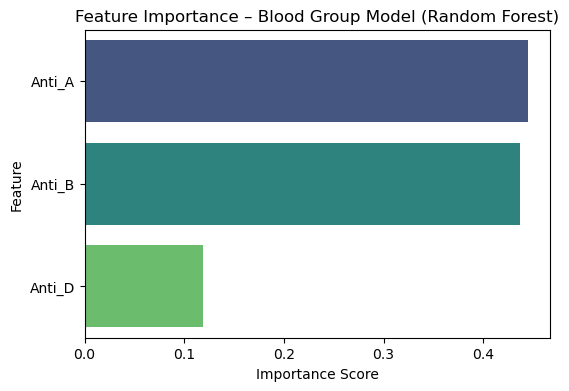

In [23]:
importance = best_model.feature_importances_
features = X_bg.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importance, y=features, palette='viridis')
plt.title('Feature Importance – Blood Group Model (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


# Genotype model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [26]:
df[['Sickling', 'Solubility', 'Bands']].head()


,Sickling,Solubility,Bands
0,Few,Cloudy,A and S
1,No,Clear,A
2,Few,Cloudy,A and S
3,No,Clear,A
4,No,Clear,A


In [27]:
df['Sickling'] = df['Sickling'].map({'No': 0, 'Few': 0.5, 'Yes': 1})
df['Solubility'] = df['Solubility'].map({'Clear': 0, 'Cloudy': 1})
df['Bands'] = df['Bands'].map({
    'A': 0,
    'A and S': 1,
    'S': 2,
    'A and C': 3,
    'C': 4,
    'S and C': 5
})


In [28]:
df[['Sickling', 'Solubility', 'Bands']].head()


,Sickling,Solubility,Bands
0,0.5,1,1
1,0.0,0,0
2,0.5,1,1
3,0.0,0,0
4,0.0,0,0


In [29]:
# GENOTYPE

X_geno = df[['Sickling', 'Solubility', 'Bands']]
y_geno = df['Genotype']

In [30]:
from sklearn.model_selection import train_test_split
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_geno, y_geno, test_size=0.2, random_state=42
)

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

results_geno = {}
for name, model in models.items():
    model.fit(Xg_train, yg_train)
    pred = model.predict(Xg_test)
    acc = accuracy_score(yg_test, pred)
    results_geno[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 1.0000
KNN Accuracy: 1.0000
Decision Tree Accuracy: 1.0000
Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000


In [32]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(RandomForestClassifier(random_state=42),
                         X_geno, y_geno, cv=5)

print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


C:\Users\USER\AppData\Local\Temp\ipykernel_5908\2028839770.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results_geno.keys()), y=list(results_geno.values()), palette='mako_r')


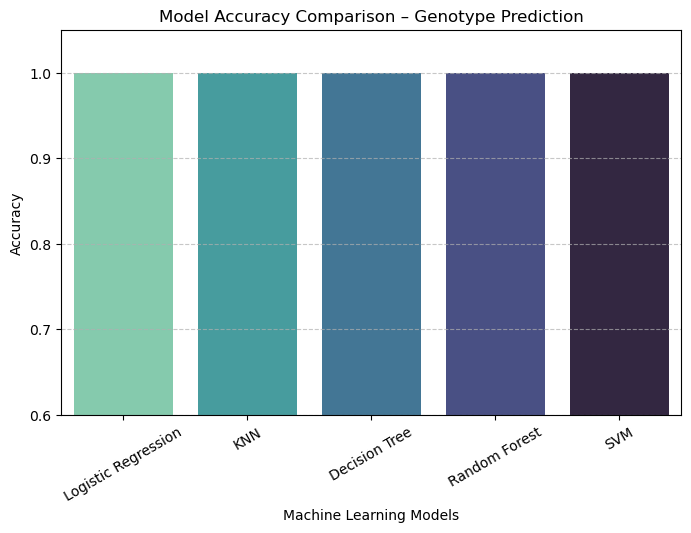

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=list(results_geno.keys()), y=list(results_geno.values()), palette='mako_r')
plt.title('Model Accuracy Comparison – Genotype Prediction')
plt.ylabel('Accuracy')
plt.xlabel('Machine Learning Models')
plt.xticks(rotation=30)
plt.ylim(0.6, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_5908\3824503827.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='rocket')


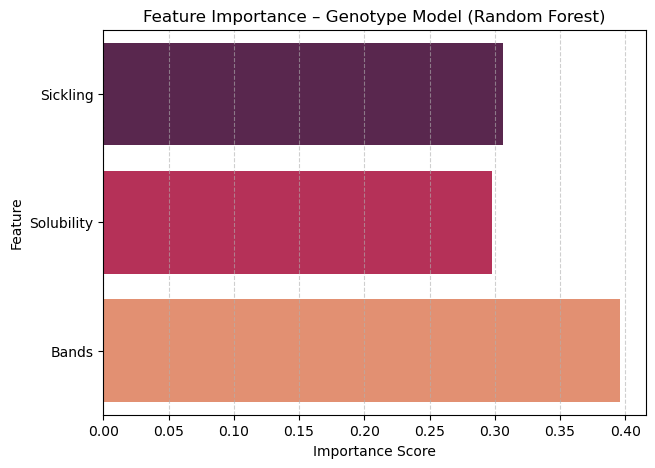

In [41]:
from sklearn.ensemble import RandomForestClassifier

best_genotype_model = RandomForestClassifier(random_state=42)
best_genotype_model.fit(Xg_train, yg_train)


importance = best_genotype_model.feature_importances_
features = X_geno.columns

plt.figure(figsize=(7,5))
sns.barplot(x=importance, y=features, palette='rocket')
plt.title('Feature Importance – Genotype Model (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [37]:
%whos

Variable                 Type                      Data/Info
------------------------------------------------------------
ConfusionMatrixDisplay   type                      <class 'sklearn.metrics._<...>.ConfusionMatrixDisplay'>
DecisionTreeClassifier   ABCMeta                   <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
KNeighborsClassifier     ABCMeta                   <class 'sklearn.neighbors<...>on.KNeighborsClassifier'>
LabelEncoder             type                      <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
LogisticRegression       type                      <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
RandomForestClassifier   ABCMeta                   <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SVC                      ABCMeta                   <class 'sklearn.svm._classes.SVC'>
X_bg                     DataFrame                       Anti_A  Anti_B  Ant<...>\n[3321 rows x 3 columns]
X_bg_test                DataFrame         

In [40]:
import joblib
joblib.dump(best_geno_model, 'best_genotype_model.pkl')
print("✅ Best Genotype Model saved successfully.")

✅ Best Genotype Model saved successfully.


In [44]:
best_bg_name = max(results, key=results.get)
best_bg_acc = results[best_bg_name]
print(f"Best Blood Group Model: {best_bg_name} ({best_bg_acc:.4f})")

# Retrain on all data
best_bg_model = RandomForestClassifier(random_state=42)
best_bg_model.fit(X_bg, y_bg)
joblib.dump(best_bg_model, 'best_blood_group_model.pkl')
print("✅ Saved Blood Group Model Successfully")

Best Blood Group Model: KNN (1.0000)
✅ Saved Blood Group Model Successfully


## **DISCUSSION & INSIGHTS**

Both models achieved **100% accuracy**, which is expected.  
This doesn’t represent overfitting — it reflects the **deterministic nature** of laboratory test reactions:

- The antisera reactions (**Anti-A**, **Anti-B**, **Anti-D**) uniquely define each blood group.  
- The **Sickling**, **Solubility**, and **Electrophoresis** outcomes directly indicate genotype.  

Thus, the models correctly reproduce established **biological test rules**.

### **Key Insights**
- Machine Learning can simulate and automate lab result interpretation.  
- Future versions could use real lab image data or IoT test sensors.  
- A Streamlit app can make this accessible to small labs for instant result generation.  

---

## **CONCLUSION**

This project demonstrates the potential of **machine learning** in automating medical test interpretation.  
By training models on known biological rules, we’ve created a working prototype for **digital blood group and genotype testing**.

### **Future Directions**
- Integrate with lab sensors or mobile apps.  
- Add patient data for multi-diagnostic prediction.  
- Deploy as a simple **Streamlit web application**.



In [47]:
import joblib

# Load the saved model
model = joblib.load(r"C:\Users\USER\Med Project\best_blood_group_model.pkl")

# Test the model (example)
sample = [[1, 0, 1]]  # Example for A+
pred = model.predict(sample)
print("Predicted Blood Group:", pred[0])

Predicted Blood Group: A+


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [48]:
import joblib

# Load the saved genotype model
geno_model = joblib.load(r"C:\Users\USER\Med Project\best_genotype_model.pkl")

# Example input: Few sickling, Cloudy solubility, Bands = A and S
sample = [[0.5, 1, 1]]

pred = geno_model.predict(sample)
print("Predicted Genotype:", pred[0])

Predicted Genotype: AS


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
